## Change code of Algorithm1 to use known cost vectors

This is same setting as 7_01, here the bug is fixed already, but the hyperparameters of Algorithm1 are after tuning.

In [1]:
import os
os.chdir('../..')
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import time
import math

import costs
from plotting.costs import plot_costs

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)

#### Setting important constants

In [4]:
TIME_POINTS = 10000
NUM_FEATURES = 4
N_ARMS = 5
# Beta parameter multiplies the reward achieved by the algorithm
BETA = 1

## Creating context vectors

In [5]:
def categorical(values, distribution, length):
    assert len(values) == len(distribution)
    values = np.array(values)
    sample = np.random.multinomial(1, distribution, size=(length,))
    indices = np.argmax(sample, axis=1)
    return values[indices]

In [6]:
values = [5,6,7,120]
distribution = [0.2, 0.1, 0.4, 0.3]
categorical(values, distribution, length=7)

array([  6,   7, 120,   7,   5,   5,   7])

In [7]:
feature_config = {
    0: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    1: {
        'values': [1, 2],
        'distribution': [0.2, 0.8],
    },
    2: {
        'values': [1, 2, 3],
        'distribution': [ 0.6, 0.3, 0.1],
    },
    3: {
        'values': [1,2,3,4],
        'distribution': [0.1, 0.2, 0.3, 0.4],
    },
    
    4: {
        'values': [1,2,3,4,5],
        'distribution': [0.15, 0.2, 0.3, 0.2, 0.15],
    },
    5: {
        'values': [1,2],
        'distribution': [0.1, 0.9],
    },
    6: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    7: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    8: {
        'values': [1,2,3,4],
        'distribution': [0.4, 0.3, 0.2, 0.1],
    },
    9: {
        'values': [1, 2,3,4,5,6,7,8,9,10,11],
        'distribution': [0.01, 0.03, 0.08, 0.12, 0.16, 0.20, 0.16, 0.12 ,0.08, 0.03, 0.01],
    },
}

In [8]:
contexts = np.zeros((TIME_POINTS, NUM_FEATURES))

for i in range(NUM_FEATURES):
    values = feature_config[i]['values']
    distribution = feature_config[i]['distribution']
    contexts[:, i] = categorical(values, distribution, length=TIME_POINTS)

In [9]:
contexts, contexts.shape

(array([[4., 2., 2., 4.],
        [4., 2., 1., 3.],
        [4., 1., 1., 3.],
        ...,
        [2., 2., 1., 4.],
        [1., 2., 1., 4.],
        [2., 2., 1., 4.]]),
 (10000, 4))

### Visualizing context features

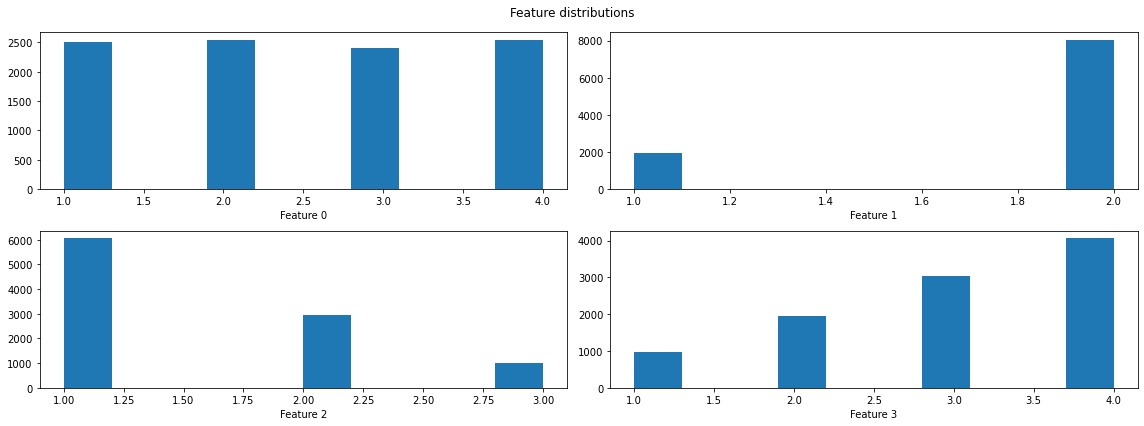

In [10]:
fig, axs = plt.subplots(2, math.ceil(NUM_FEATURES/2), figsize=(16,6))
for i, ax in zip(range(NUM_FEATURES), axs.flatten()):
    ax.hist(contexts[:, i])
    ax.set_xlabel(f"Feature {i}")
fig.suptitle('Feature distributions')
plt.tight_layout()

## Creating cost vectors

In [11]:
# Mean of gaussian distribution random in interval
interval_means_raw = np.array([np.random.uniform(0, 0.10, size=(NUM_FEATURES,)) for i in range(5)])

In [12]:
interval_means_raw

array([[0.06433543, 0.00585418, 0.02470971, 0.01538839],
       [0.02906733, 0.03288553, 0.04951968, 0.05201386],
       [0.0630098 , 0.03316521, 0.05320212, 0.09901173],
       [0.02106393, 0.01527058, 0.08425641, 0.04103656],
       [0.08468837, 0.0424689 , 0.00216849, 0.0374873 ]])

In [13]:
interval_means = interval_means_raw * BETA

In [14]:
# Fixed std
interval_stds = [[0.001]*NUM_FEATURES]*5

In [15]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=NUM_FEATURES,
        change_points=[3000, 4500, 5500, 8000],
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

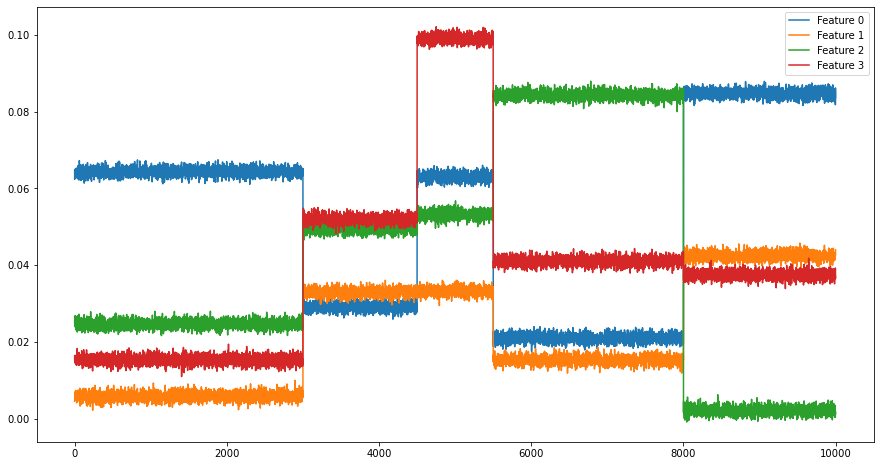

In [16]:
plot_costs(get_costs(), 10000)

In [17]:
costs_obj = get_costs()

In [18]:
costs_vector = []
for t in range(TIME_POINTS):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [19]:
costs_vector.shape

(10000, 4)

## Creating rewards

In [20]:
rewards = np.zeros((TIME_POINTS, N_ARMS))

In [21]:
slices = [
    slice(0,500),
    slice(500,1000),
    slice(1000,2000),
    slice(2000,3500),
    slice(3500,5000),
    slice(5000,6500),
    slice(6500,8000),
    slice(8000,10000),
]

In [22]:
# old version
reward_config = {
    0: [
        0.28, 0.22 , 0.19 , 0.2 , 0.27 ,
    ],
    1: [
        0.24, 0.7 , 0.2 , 0.27 , 0.25 ,
    ],
    2: [
        0.22, 0.19 , 0.9 , 0.37 , 0.29 ,
    ],
    3: [
        0.36, 0.19 , 0.22 , 0.8 , 0.2 ,
    ],
    4: [
        0.26, 0.27 , 0.28 , 0.34 , 0.94 ,
    ],
    5: [
        0.77, 0.35 , 0.31 , 0.38 , 0.35 ,
    ],
    6: [
        0.2, 0.8 , 0.24 , 0.24 , 0.21 ,
    ],
    7: [
        0.2, 0.22 , 0.9 , 0.37 , 0.29 ,
    ],
}

In [23]:
# Here reward is stationary for given slice, arm.
# So piece-wise stationary for a given arm, not depending on context.

mean_rewards = np.zeros(rewards.shape)


for i, interval_slice in enumerate(slices):
    context_slice = contexts[interval_slice, :]
    slice_len = context_slice.shape[0]
    print(f"Slice {i}:")
    high_reward_arm = np.random.choice(N_ARMS)
    
    high_reward_arm = i % N_ARMS
    for arm in range(N_ARMS):

        # Use p from config (reward range is config)
#         if arm == high_reward_arm:
#             reward_range = HIGH_REWARD_RANGE
#         else:
#             reward_range = LOW_REWARD_RANGE
        
#         p = np.random.uniform(reward_range[0], reward_range[1])

        p = reward_config[i][arm]

        # Sample rewards from the obtained distribution.
        slice_rewards = np.random.binomial(n=1, p=p, size=(slice_len,))
        rewards[interval_slice, arm] = slice_rewards
        
        # Check that thetas found by linear regression give estimation of expected reward close to
        # true expected reward. 
        
        # thetas found by solving linear regression problem
        linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)
        
        estimated_reward = np.mean(context_slice @ linreg_theta, axis=0)
        
        print(
            f"  Arm {arm}: p={np.mean(p):.2f}, mean reward={np.mean(slice_rewards):.2f}",
            f"  reward estimated by linear regression {estimated_reward:.2f}", 
        )
        
        # for visualization
        mean_rewards[interval_slice, arm] = np.ones(slice_rewards.shape) * np.mean(slice_rewards)

    

Slice 0:
  Arm 0: p=0.28, mean reward=0.27   reward estimated by linear regression 0.27
  Arm 1: p=0.22, mean reward=0.24   reward estimated by linear regression 0.23
  Arm 2: p=0.19, mean reward=0.19   reward estimated by linear regression 0.19
  Arm 3: p=0.20, mean reward=0.20   reward estimated by linear regression 0.19
  Arm 4: p=0.27, mean reward=0.26   reward estimated by linear regression 0.26
Slice 1:
  Arm 0: p=0.24, mean reward=0.25   reward estimated by linear regression 0.24
  Arm 1: p=0.70, mean reward=0.71   reward estimated by linear regression 0.69
  Arm 2: p=0.20, mean reward=0.18   reward estimated by linear regression 0.18
  Arm 3: p=0.27, mean reward=0.26   reward estimated by linear regression 0.25
  Arm 4: p=0.25, mean reward=0.27   reward estimated by linear regression 0.27
Slice 2:
  Arm 0: p=0.22, mean reward=0.22   reward estimated by linear regression 0.21
  Arm 1: p=0.19, mean reward=0.17   reward estimated by linear regression 0.17
  Arm 2: p=0.90, mean rew

/var/folders/_g/d2bwsxss6v9_1830lrh6wyth0000gn/T/ipykernel_60527/2779309452.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)


### Visualising rewards

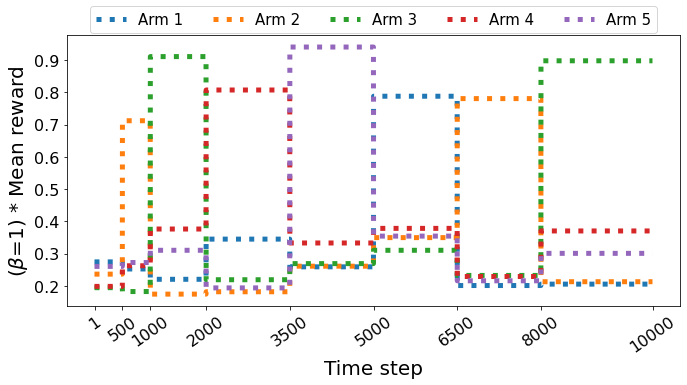

In [24]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(N_ARMS):
    ax.plot(BETA * mean_rewards[:, arm], label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    

    
extraticks = [1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 10000]
plt.xticks(extraticks, rotation=35, fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


## Plot reward - sum of feature costs

Min expected gain for arm 1: 0.004013248304766404
Min expected gain for arm 2: 0.006013248304766405
Min expected gain for arm 3: 0.014013248304766412
Min expected gain for arm 4: 0.06046667932907712
Min expected gain for arm 5: 0.024774358661449863


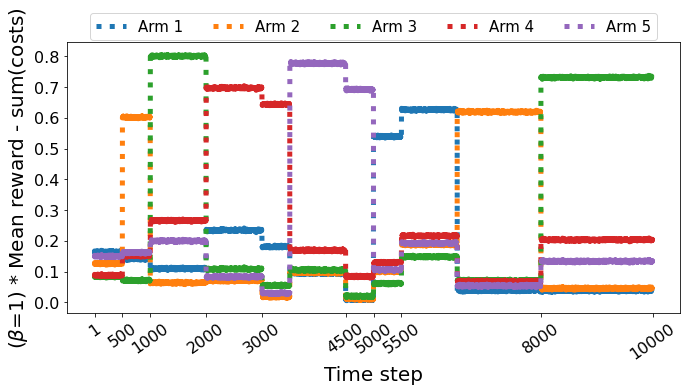

In [25]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(N_ARMS):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = [1, 500, 1000, 2000, 3000, 4500, 5000, 5500, 8000, 10000]
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


In [26]:
rewards.shape

(10000, 5)

In [27]:
costs_vector.shape

(10000, 4)

In [28]:
rewards

array([[1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [0., 0., 1., 0., 0.]])

In [29]:
data = (contexts, rewards, costs_vector)

In [30]:
# import pickle

# with open('dataset/synthetic/synthetic_data.pickle', 'wb') as f:
#     pickle.dump(data, f)

## Testing algorithms on synthetic data

In [31]:
%load_ext autoreload
%autoreload 2

import algorithms
import evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
NUM_OF_TRIALS = 10000

In [33]:
NUM_REPETITIONS = 5

In [34]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random = evaluation.evaluate_on_synthetic_data(
        p_random,
        contexts,
        rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_random
    
gain_random = np.mean(gains, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Beta = 1
Total gain: 3736.0
	Total reward: 3736.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3745.0
	Total reward: 3745.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3741.0
	Total reward: 3741.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3815.0
	Total reward: 3815.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3837.0
	Total reward: 3837.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3774.8


In [35]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.1, n_arms=rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        contexts,
        rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.1)
Beta = 1
Total gain: 4544.0
	Total reward: 4544.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.1)
Beta = 1
Total gain: 3969.0
	Total reward: 3969.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.1)
Beta = 1
Total gain: 4383.0
	Total reward: 4383.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.1)
Beta = 1
Total gain: 4684.0
	Total reward: 4684.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.1)
Beta = 1
Total gain: 4684.0
	Total reward: 4684.0
	Total cost: 0
Execution time: 0.1s
Average gain: 4452.8


In [36]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    ucb_alg = algorithms.UCB1(
        n_trials=NUM_OF_TRIALS,
        n_arms=rewards.shape[1],
        alpha=0.45,
    )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        contexts,
        rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_ucb
    
gain_ucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.45)
Beta = 1
Total gain: 3767.0
	Total reward: 3767.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.45)
Beta = 1
Total gain: 3767.0
	Total reward: 3767.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.45)
Beta = 1
Total gain: 3767.0
	Total reward: 3767.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.45)
Beta = 1
Total gain: 3767.0
	Total reward: 3767.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.45)
Beta = 1
Total gain: 3767.0
	Total reward: 3767.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3767.0


In [37]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=contexts.shape[1],
        n_arms=rewards.shape[1],
        alpha=0.5,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        contexts,
        rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_linucb

gain_linucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.5)
Beta = 1
Total gain: 2750.7035697376355
	Total reward: 4313.0
	Total cost: 1562.2964302623614
Execution time: 0.4s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 2750.7035697376355
	Total reward: 4313.0
	Total cost: 1562.2964302623614
Execution time: 0.4s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 2750.7035697376355
	Total reward: 4313.0
	Total cost: 1562.2964302623614
Execution time: 0.5s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 2750.7035697376355
	Total reward: 4313.0
	Total cost: 1562.2964302623614
Execution time: 0.3s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 2750.7035697376355
	Total reward: 4313.0
	Total cost: 1562.2964302623614
Execution time: 0.4s
Average gain: 2750.7035697376355


In [38]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=contexts.shape[1],
        n_arms=rewards.shape[1],
        alpha=0.7,
        omega=100,
        delta=0.03,
    )


    gain_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        contexts,
        rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    change_points = ps_linucb.change_points
    gains[i, :] = gain_pslinucb

gain_pslinucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5656.703569737658
	Total reward: 7219.0
	Total cost: 1562.2964302623614
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5656.703569737658
	Total reward: 7219.0
	Total cost: 1562.2964302623614
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5656.703569737658
	Total reward: 7219.0
	Total cost: 1562.2964302623614
Execution time: 0.8s
PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5656.703569737658
	Total reward: 7219.0
	Total cost: 1562.2964302623614
Execution time: 0.7s
PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5656.703569737658
	Total reward: 7219.0
	Total cost: 1562.2964302623614
Execution time: 0.9s
Average gain: 5656.703569737658


In [39]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=contexts, 
        number_of_actions=rewards.shape[1],
        max_no_red_context=contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.2,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            contexts[:NUM_OF_TRIALS],
            rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_simoos

gain_simoos = np.mean(gains, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0015490055084228516 seconds
Trial 0, time 2022-04-27 10:09:50.052339
Trial 500, time 2022-04-27 10:09:55.771882
Trial 1000, time 2022-04-27 10:09:56.684546
Trial 1500, time 2022-04-27 10:09:57.803207
Trial 2000, time 2022-04-27 10:09:58.433193
Trial 2500, time 2022-04-27 10:09:58.786831
Trial 3000, time 2022-04-27 10:09:59.139276
Trial 3500, time 2022-04-27 10:09:59.610035
Trial 4000, time 2022-04-27 10:10:00.193859
Trial 4500, time 2022-04-27 10:10:00.278667
Trial 5000, time 2022-04-27 10:10:00.701664
Trial 5500, time 2022-04-27 10:10:01.215535
Trial 6000, time 2022-04-27 10:10:01.714188
Trial 6500, time 2022-04-27 10:10:01.906066
Trial 7000, time 2022-04-27 10:10:02.041380
Trial 7500, time 2022-04-27 10:10:03.191452
Trial 8000, time 2022-04-27 10:10:04.289891
Trial 8500, time 2022-04-27 10:10:05.678565
Trial 9000, time 2022-04-27 10:10:05.859138
Trial 9500, time 2022-04-27 10:10:05.931227
SimOOS (beta=1, delta=0.2)
Beta = 1
Total gain: 3583.9843893264256
	Total reward: 4199.0


In [40]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1 = algorithms.Algorithm1(
        all_contexts=contexts, 
        number_of_actions=rewards.shape[1],
        max_no_red_context=contexts.shape[1],
        beta=BETA,
        delta=0.03,
        window_length=100,
        oracle_costs=True,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1 = evaluation.evaluate_on_synthetic_data(
            p_alg1,
            contexts[:NUM_OF_TRIALS],
            rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_alg1

gain_alg1 = np.mean(gains, axis=0)
print(f"Average gain: {gain_alg1[-1]}")

Took 0.0016658306121826172 seconds
Round 0, time 2022-04-27 10:11:21.047139
Round 500, time 2022-04-27 10:11:50.472702
Round 1000, time 2022-04-27 10:12:20.834017
Round 1500, time 2022-04-27 10:12:51.293853
Round 2000, time 2022-04-27 10:13:21.524701
Round 2500, time 2022-04-27 10:13:51.523064
Round 3000, time 2022-04-27 10:14:22.355159
Round 3500, time 2022-04-27 10:14:53.596364
Round 4000, time 2022-04-27 10:15:24.434773
Round 4500, time 2022-04-27 10:15:55.612919
Round 5000, time 2022-04-27 10:16:26.793057
Round 5500, time 2022-04-27 10:16:57.786235
Round 6000, time 2022-04-27 10:17:28.479416
Round 6500, time 2022-04-27 10:17:58.841755
Round 7000, time 2022-04-27 10:18:30.240120
Round 7500, time 2022-04-27 10:19:01.474845
Round 8000, time 2022-04-27 10:19:32.356334
Round 8500, time 2022-04-27 10:20:03.551539
Round 9000, time 2022-04-27 10:20:33.820619
Round 9500, time 2022-04-27 10:21:03.572463
Algorithm1 (beta=1, delta=0.03, w=100)
Beta = 1
Total gain: 4078.1908901380953
	Total rew

### Plot cumulative gain

In [41]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind % 7]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = [1, 500, 1000, 2000, 3500, 5000]
    plt.xticks( extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    
    plt.legend(prop={'size': 16});
#     plt.savefig('gain_synthetic.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

    
    plt.show();

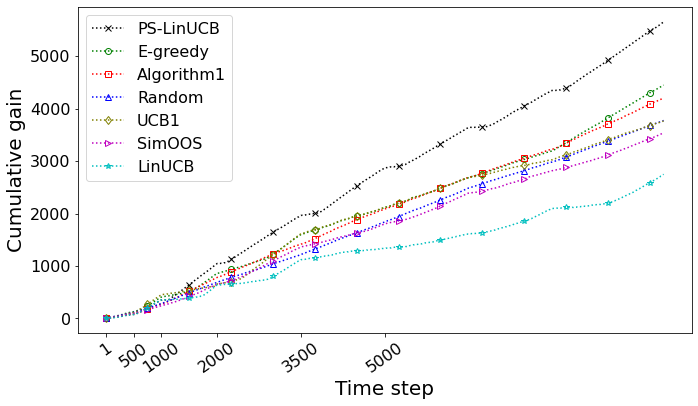

In [42]:
plot_gains({
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
},
)


In [43]:
p_alg1.random_actions

3526

In [44]:
list(p_alg1.nus)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.

In [45]:
list(p_alg1.selected_action_SimOOS)

[2.0,
 2.0,
 0.0,
 1.0,
 2.0,
 0.0,
 3.0,
 4.0,
 2.0,
 0.0,
 2.0,
 0.0,
 0.0,
 4.0,
 4.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 2.0,
 2.0,
 0.0,
 1.0,
 3.0,
 1.0,
 4.0,
 0.0,
 4.0,
 1.0,
 0.0,
 0.0,
 2.0,
 1.0,
 1.0,
 1.0,
 3.0,
 2.0,
 2.0,
 3.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 4.0,
 1.0,
 0.0,
 3.0,
 4.0,
 4.0,
 1.0,
 1.0,
 3.0,
 2.0,
 2.0,
 4.0,
 3.0,
 4.0,
 2.0,
 1.0,
 4.0,
 3.0,
 1.0,
 0.0,
 1.0,
 4.0,
 2.0,
 1.0,
 3.0,
 0.0,
 4.0,
 4.0,
 0.0,
 1.0,
 4.0,
 4.0,
 1.0,
 3.0,
 4.0,
 3.0,
 2.0,
 2.0,
 3.0,
 1.0,
 4.0,
 3.0,
 1.0,
 3.0,
 3.0,
 4.0,
 0.0,
 1.0,
 4.0,
 3.0,
 3.0,
 0.0,
 4.0,
 3.0,
 1.0,
 4.0,
 3.0,
 4.0,
 4.0,
 4.0,
 2.0,
 4.0,
 4.0,
 1.0,
 1.0,
 4.0,
 4.0,
 0.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 0.0,
 1.0,
 4.0,
 1.0,
 0.0,
 0.0,
 1.0,
 4.0,
 4.0,
 2.0,
 2.0,
 3.0,
 0.0,
 4.0,
 4.0,
 1.0,
 2.0,
 2.0,
 4.0,
 1.0,
 3.0,
 0.0,
 1.0,
 1.0,
 3.0,
 1.0,
 1.0,
 1.0,
 3.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 3.0,
 4.0,
 2.0,
 2.0,
 1.0,
 3.0,
 4.0,
 4.0

In [46]:
list(p_alg1.selected_context_SimOOS[:])

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 1.]),
 array([0., 0., 1., 0.]),
 array([0., 0., 1., 1.]),
 array([0., 1., 0., 0.]),
 array([0., 1., 0., 1.]),
 array([0., 1., 1., 0.]),
 array([0., 1., 1., 1.]),
 array([1., 0., 0., 0.]),
 array([1., 0., 0., 1.]),
 array([1., 0., 1., 0.]),
 array([1., 0., 1., 1.]),
 array([1., 1., 0., 0.]),
 array([1., 1., 0., 1.]),
 array([1., 1., 1., 0.]),
 array([1., 1., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 

In [47]:
list(p_alg1.costs)

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0.06504665, 0.00664752, 0.02436099, 0.01492603]),
 array([0.0651934 , 0.00566287, 0.02343403, 0.0142551 ]),
 array([0.06341598, 0.00635134, 0.02485214, 0.01607887]),
 array([0.06390818, 0.00601272, 0.0253353 , 0.01507904]),
 array([0.0647922 , 0.00519225, 0.02434666, 0.01500665]),
 array([0.06313959, 0.00634115, 0.02424031, 0.01540088]),
 array([0.06481617, 0.00630071, 0.0253751 , 0.0152899 ]),
 array([0.06391213, 0.00577446, 0.02302238, 0.01394127]),
 array([0.06301273, 0.00485693, 0.02510949, 0.01448291]),
 array([0.06395727, 0.00715341, 0.02435345, 0.0161259 ]),
 arr

In [48]:
list(p_alg1.c_hats)

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0.06402261, 0.00577253, 0.02515018, 0.01527402]),
 array([0.06402261, 0.00577253, 0.02506249, 0.01523535]),
 array([0.0641527 , 0.00576035, 0.02489964, 0.01513733]),
 array([0.06407903, 0.00581945, 0.02489532, 0.01522292]),
 array([0.0640635 , 0.00583702, 0.02493199, 0.01521093]),
 array([0.06412422, 0.00578329, 0.02488696, 0.01519522]),
 array([0.06412422, 0.00578329, 0.02484077, 0.01520991]),
 array([0.06412422, 0.00578329, 0.02487639, 0.01521524]),
 array([0.06412422, 0.00578329, 0.02476052, 0.01513562]),
 array([0.06412422, 0.00578329, 0.02478105, 0.01509722]),
 arr

In [49]:
list(p_alg1.cost_conf_int)

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([1.08132912, 1.08132912, 1.08132912, 1.08132912]),
 array([1.08132912, 1.08132912, 1.01948688, 1.01948688]),
 array([1.01948688, 1.01948688, 0.96717017, 0.96717017]),
 array([0.96717017, 0.96717017, 0.92216058, 0.92216058]),
 array([0.92216058, 0.92216058, 0.88290153, 0.88290153]),
 array([0.88290153, 0.88290153, 0.84826436, 0.84826436]),
 array([0.88290153, 0.88290153, 0.81740799, 0.81740799]),
 array([0.88290153, 0.88290153, 0.78969114, 0.78969114]),
 array([0.88290153, 0.88290153, 0.76461516, 0.76461516]),
 array([0.88290153, 0.88290153, 0.74178566, 0.74178566]),
 arr

## Debugging

## PS-LinUCB for comparison

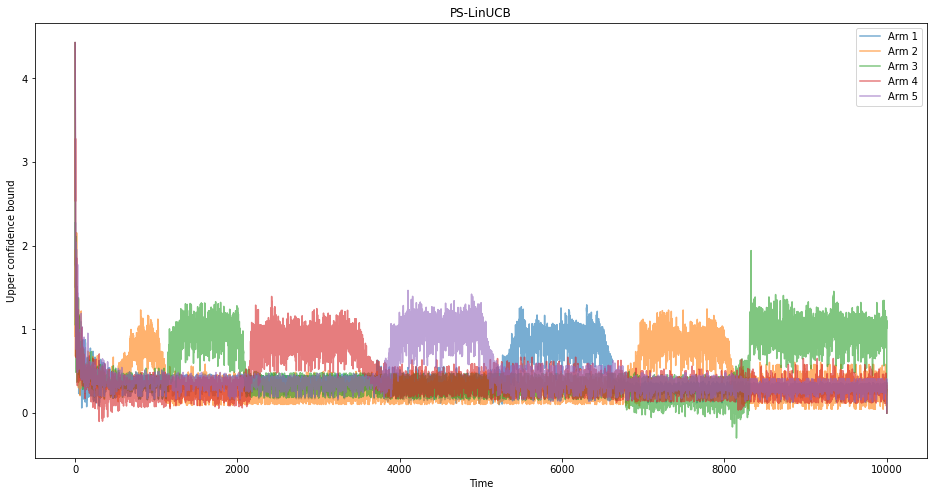

In [50]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(ps_linucb.ucbs[:, i], label=f"Arm {i+1}", alpha=0.6);
ax.set_title('PS-LinUCB');
ax.set_xlabel('Time');
ax.set_ylabel('Upper confidence bound');
plt.legend();

In [51]:
# fig, ax = plt.subplots(1,1, figsize=(16, 8))
# for i in range(5):
#     ax.plot(ps_linucb.rewards[:, i], label=f"Arm {i+1}", alpha=0.6);
# ax.set_title('PS-LinUCB - rewards');
# ax.set_xlabel('Time');
# ax.set_ylabel('Upper confidence bound');
# plt.legend();

In [52]:


# fig, ax = plt.subplots(5,1, figsize=(15, 15))
# fig.suptitle('Upper confidence bounds for PS-LinUCB')
# for i in range(5):
#     ax[i].plot(ps_linucb.ucbs[:NUM_OF_TRIALS, i], color=plt.cm.tab10(i));
#     ax[i].set_title(f"PS-LinUCB - arm {i+1}");
#     ax[i].set_ylabel('Upper confidence bound');
#     ax[i].set_ylim([0.0, 2.3])

# plt.tight_layout();

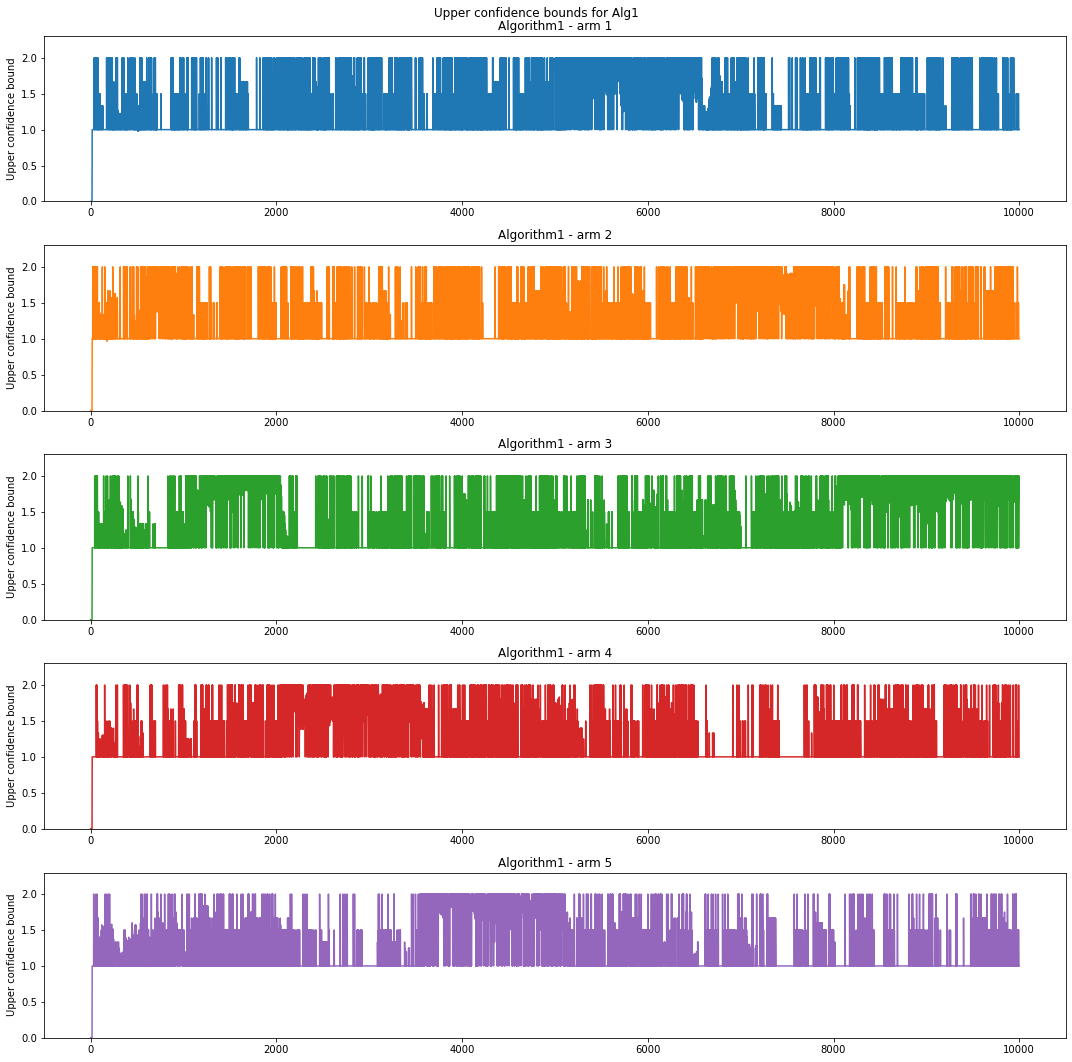

In [53]:


fig, ax = plt.subplots(5,1, figsize=(15, 15))
fig.suptitle('Upper confidence bounds for Alg1')
for i in range(5):
    ax[i].plot(p_alg1.ucbs[:NUM_OF_TRIALS, i], color=plt.cm.tab10(i));
    ax[i].set_title(f"Algorithm1 - arm {i+1}");
    ax[i].set_ylabel('Upper confidence bound');
    ax[i].set_ylim([0.0, 2.3])

plt.tight_layout();

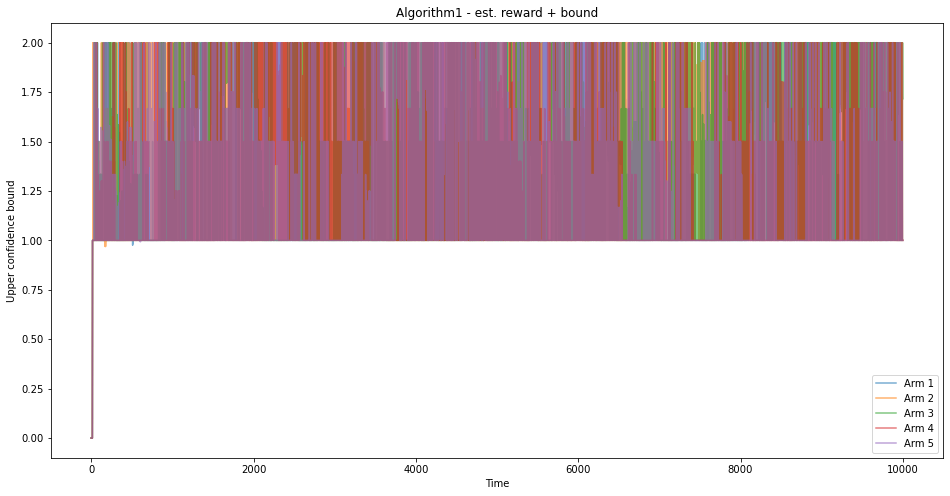

In [54]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(p_alg1.ucbs[:NUM_OF_TRIALS, i], label=f"Arm {i+1}", alpha=0.6);
ax.set_title('Algorithm1 - est. reward + bound');
ax.set_xlabel('Time');
ax.set_ylabel('Upper confidence bound');
plt.legend();

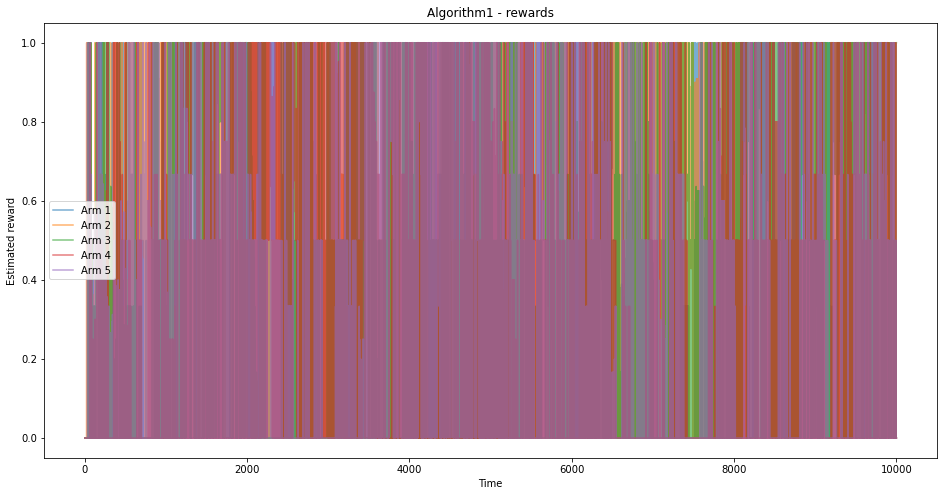

In [55]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(p_alg1.rewards[:NUM_OF_TRIALS, i], label=f"Arm {i+1}", alpha=0.6);
ax.set_title('Algorithm1 - rewards');
ax.set_xlabel('Time');
ax.set_ylabel('Estimated reward');
plt.legend();

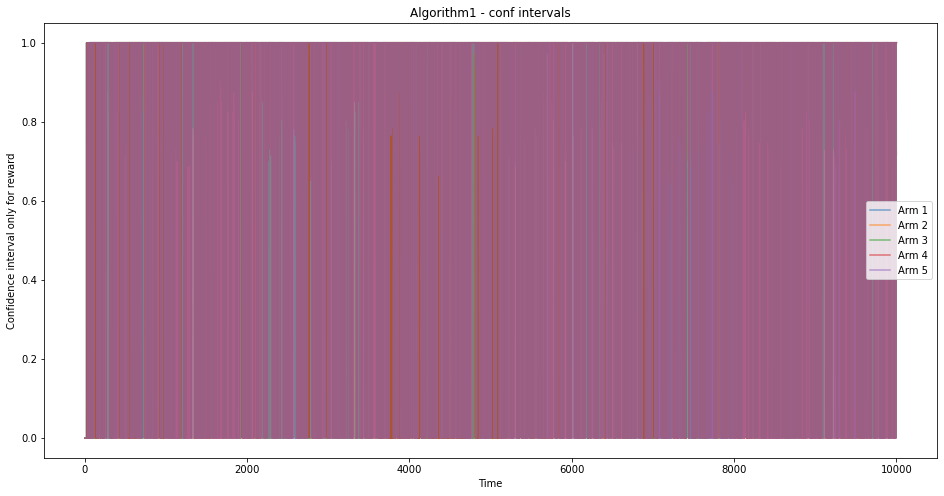

In [56]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(p_alg1.confidences[:NUM_OF_TRIALS, i], label=f"Arm {i+1}", alpha=0.6);
ax.set_title('Algorithm1 - conf intervals');
ax.set_xlabel('Time');
ax.set_ylabel('Confidence interval only for reward');
plt.legend();

I found an apparent bug in the code:
In this commit:
https://github.com/SaeedGhoorchian/costly_nonstationary_bandits/commit/8db7c16665eb28ed87ffa63ddda5d8f1cc6ed2fd#diff-427612d30394461253511a5de400852f2b83d07df2e59cf256d38f93924f4b0cR283
I added the min(1, value) operation to computing the N_t_aso, but several other places in the code were critically dependant on seeing zeros inside N_t_aso. These parts of the code influenced the exploration of the algorithm. 
So I changed the update of N_t_aso here:
https://github.com/SaeedGhoorchian/costly_nonstationary_bandits/commit/3907b9621153c447be17925879e98d8f9e6f6cdb

Let's see how the result plays out.